# Notatnik zawiera "brudnopis" rozwiązań zadań NN3. Wszystkie zbiory poza square large mają swój dedykowany plik .py gdzie jest oficjalna, czysta wersja rozwiązania. W sekcji square large tego notanika, widać moje próby jak i ostateczne dwukrotne osiągnięcie MSE <3. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)
def cost_derivative(output_activations, y):
    return output_activations - y




In [3]:
np.random.seed(41)

In [361]:
class MLP:
    def __init__(self, layer_sizes, scaler, verbose=False, beta_momentum=0.90, beta_rmsprop=0.999, epsilon=1e-8):

        self.layer_sizes = layer_sizes
        # Decided to use he method for initialization
        self.weights = [
            np.random.randn(y, x) * np.sqrt(2.0 / x)
            for x, y in zip(layer_sizes[:-1], layer_sizes[1:])
        ]
        self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]
        self.scaler = scaler
        self.beta_momentum = beta_momentum
        self.beta_rmsprop = beta_rmsprop
        self.epsilon = epsilon
        # Initialize momentum and RMSprop caches
        self.vdw = [np.zeros_like(w) for w in self.weights]
        self.sdw = [np.zeros_like(w) for w in self.weights]
        self.vdb = [np.zeros_like(b) for b in self.biases]
        self.sdb = [np.zeros_like(b) for b in self.biases]
        self.verbose = verbose
        if self.verbose:
            print("Initial weights: ", self.weights)

    def plot_weights(self, epoch):
        for i, w in enumerate(self.weights):
            plt.figure(figsize=(40, 20))
            plt.hist(w.flatten(), bins=50)
            plt.title(f"Layer {i + 1} Weight Distribution")
            plt.xlabel("Weight Value")
            plt.ylabel("Frequency")

            filename = f"epoch_{epoch}_layer_{i + 1}_weights_distribution.png"
            filepath = f"weights_plots/multimodal-large/{filename}"

            # Save the plot to file
            plt.savefig(filepath)

            plt.clf()

    def print_final_weights_and_biases(self):
        print("Final Weights and Biases:", self.weights, self.biases)

        for i, w in enumerate(self.weights):
            plt.figure(figsize=(40, 20))
            plt.hist(w.flatten(), bins=50)
            plt.title(f"Layer {i + 1} Weight Distribution")
            plt.xlabel("Weight Value")
            plt.ylabel("Frequency")

            filename = f"final_layer_{i + 1}_weights_distribution.png"
            filepath = f"weights_plots/multimodal-large/{filename}"

            # Save the plot to file
            plt.savefig(filepath)

            plt.clf()

    def feedforward(self, a):
        activations = [a]  # Stores all activations
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            a = relu(np.dot(w, a) + b)
            activations.append(a)
        # Linear activation for the last layer
        a = np.dot(self.weights[-1], a) + self.biases[-1]
        activations.append(a)
        return (
            activations[-1],
            activations,
        )  # Return final activation and all activations

    def real_mse(self, training_data):
        X_scaled = np.array([x for x, y in training_data])
        train_predictions_scaled = np.array(
            [self.feedforward(x.reshape(-1, 1))[0] for x in X_scaled]
        )
        y_true_scaled = np.array([y for x, y in training_data])
        # Inverse transform the predictions and the true y values
        train_predictions = self.scaler.inverse_transform(train_predictions_scaled.reshape(-1, 1))
        y_true = self.scaler.inverse_transform(y_true_scaled)
        # Calculate MSE on the denormalized values
        mse_score_train = mse(train_predictions, y_true)
        return mse_score_train

    def backprop(self, x, y):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        final_output, activations = self.feedforward(x)
        zs = [
            np.dot(w, act) + b
            for w, b, act in zip(self.weights, self.biases, activations[:-1])
        ]  # Z values

        # Output layer error
        delta = cost_derivative(final_output, y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        # Backpropagate the error
        for l in range(2, len(self.layer_sizes)):
            sp = relu_derivative(zs[-l])
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].T)

        return nabla_w, nabla_b

    def update_mini_batch(self, mini_batch, learning_rate, lambda_, n):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        for x, y in mini_batch:
            delta_nabla_w, delta_nabla_b = self.backprop(x, y)
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]

        # Update velocities for weights
        self.vdw = [self.beta_momentum * v + (1 - self.beta_momentum) * nw for v, nw in zip(self.vdw, nabla_w)]
        self.vdb = [self.beta_momentum * v + (1 - self.beta_momentum) * nb for v, nb in zip(self.vdb, nabla_b)]

        # Update squared gradients for weights
        self.sdw = [self.beta_rmsprop * s + (1 - self.beta_rmsprop) * (nw ** 2) for s, nw in zip(self.sdw, nabla_w)]
        self.sdb = [self.beta_rmsprop * s + (1 - self.beta_rmsprop) * (nb ** 2) for s, nb in zip(self.sdb, nabla_b)]

        # Correct the bias for initial iterations for both velocity and squared gradients
        vdw_corrected = [v / (1 - self.beta_momentum ** (i + 1)) for i, v in enumerate(self.vdw)]
        vdb_corrected = [v / (1 - self.beta_momentum ** (i + 1)) for i, v in enumerate(self.vdb)]
        sdw_corrected = [s / (1 - self.beta_rmsprop ** (i + 1)) for i, s in enumerate(self.sdw)]
        sdb_corrected = [s / (1 - self.beta_rmsprop ** (i + 1)) for i, s in enumerate(self.sdb)]

        # Update weights and biases with L2 regularization, RMSprop and Momentum
        self.weights = [(1 - learning_rate * (lambda_ / n)) * w - (learning_rate / len(mini_batch)) * (
                v / (np.sqrt(s) + self.epsilon))
                        for w, v, s in zip(self.weights, vdw_corrected, sdw_corrected)]
        self.biases = [b - (learning_rate / len(mini_batch)) * (v / (np.sqrt(s) + self.epsilon))
                       for b, v, s in zip(self.biases, vdb_corrected, sdb_corrected)]

    def train(
            self,
            training_data,
            epochs,
            learning_rate,
            batch_size,
            adaptive_learning_rate=True,
            test_data=None,
            treshold_mse_train=-(np.inf),
            treshold_mse_test=-(np.inf),
            lambda_=0.0,
            update_method="batch",
            plot_interval=None,
    ):
        n = len(training_data)
        learning_rate_init = learning_rate

        for j in range(epochs):
            if j % (epochs / 100) == 0:
                print("Epoch: ", j)

                mse_train = self.real_mse(training_data)
                print(mse_train)
                if test_data:
                    mse_test = self.real_mse(test_data)
                    if mse_train < treshold_mse_train:
                        print(mse_test)
                        if mse_test < treshold_mse_test:
                            break
            # Plot weights at the specified interval
            if self.verbose and plot_interval and j % plot_interval == 0:
                self.plot_weights(epoch=j)

            np.random.shuffle(training_data)
            if update_method == "batch":
                mini_batches = [
                    training_data[k: k + batch_size] for k in range(0, n, batch_size)
                ]
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, learning_rate, lambda_, n)
            elif update_method == "epoch":
                self.update_mini_batch(training_data, learning_rate, lambda_, n)
                
            if adaptive_learning_rate:
                # Learning rate schedule
                #learning_rate = learning_rate_init / (1 + 0.1 * j)
                if j % 10 == 0:
                    learning_rate *= 0.8


In [5]:
class DataScaler:
    def __init__(self, method="standardization"):
        self.method = method
        self.min = None
        self.max = None
        self.mean = None
        self.std = None

    def fit_transform(self, data):
        if self.method == "min_max":
            return self.fit_transform_min_max(data)
        elif self.method == "standardization":
            return self.fit_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def transform(self, data):
        if self.method == "min_max":
            return self.transform_min_max(data)
        elif self.method == "standardization":
            return self.transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def inverse_transform(self, data):
        if self.method == "min_max":
            return self.inverse_transform_min_max(data)
        elif self.method == "standardization":
            return self.inverse_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def fit_transform_min_max(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform_min_max(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform_min_max(self, data):
        return data * (self.max - self.min) + self.min

    def fit_transform_standardization(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return (data - self.mean) / self.std

    def transform_standardization(self, data):
        return (data - self.mean) / self.std

    def inverse_transform_standardization(self, data):
        return data * self.std + self.mean


## WCZYTANIE DANYCH

In [95]:
df_train_multimodal = pd.read_csv("mio1/regression/multimodal-large-training.csv")
X_train_multimodal = df_train_multimodal["x"].values.reshape(-1, 1)
y_train_multimodal = df_train_multimodal["y"].values.reshape(-1, 1)

df_test_multimodal = pd.read_csv("mio1/regression/multimodal-large-test.csv")
X_test_multimodal = df_test_multimodal["x"].values.reshape(-1, 1)
y_test_multimodal = df_test_multimodal["y"].values.reshape(-1, 1)


df_train_square = pd.read_csv("mio1/regression/square-large-training.csv")
X_train_square = df_train_square["x"].values.reshape(-1, 1)
y_train_square = df_train_square["y"].values.reshape(-1, 1)

df_test_square = pd.read_csv("mio1/regression/square-large-test.csv")
X_test_square = df_test_square["x"].values.reshape(-1, 1)
y_test_square = df_test_square["y"].values.reshape(-1, 1)


df_train_steps = pd.read_csv("mio1/regression/steps-large-training.csv")
X_train_steps = df_train_steps["x"].values.reshape(-1, 1)
y_train_steps = df_train_steps["y"].values.reshape(-1, 1)

df_test_steps = pd.read_csv("mio1/regression/steps-large-test.csv")
X_test_steps = df_test_steps["x"].values.reshape(-1, 1)
y_test_steps = df_test_steps["y"].values.reshape(-1, 1)

## MULTIMODAL LARGE

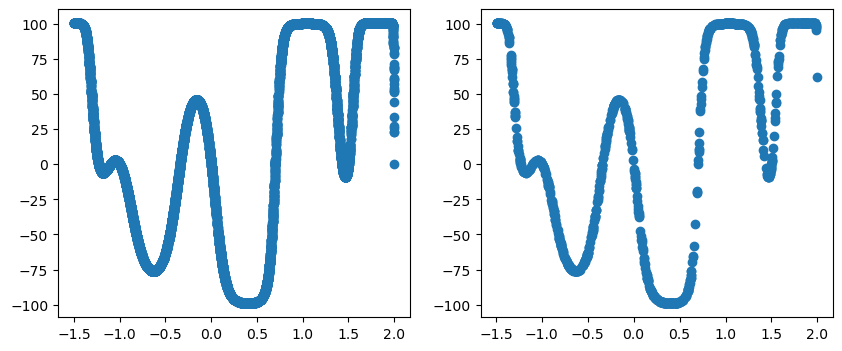

In [8]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_train_multimodal, y_train_multimodal)


plt.subplot(1, 2, 2)
plt.scatter(X_test_multimodal, y_test_multimodal)
plt.show()

In [277]:
scaler_X = DataScaler(method="min_max")
scaler_y = DataScaler(method="min_max")

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_multimodal)
y_train_scaled = scaler_y.fit_transform(y_train_multimodal)

In [90]:
mlp_multimodal = MLP([1, 64, 32, 32, 1], scaler=scaler_y, verbose=False)

In [91]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]
mlp_multimodal.train(
    training_data_scaled, epochs=200, learning_rate=1, batch_size=100, plot_interval=20
)

# Scale the test data using the transform method (DO NOT refit scaler)
X_test_scaled = scaler_X.transform(X_test_multimodal)

# Generate predictions on the scaled test data and inverse transform
predictions_scaled = np.array(
    [mlp_multimodal.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

train_predictions_scaled = np.array(
    [mlp_multimodal.feedforward(x.reshape(-1, 1))[0] for x in X_train_scaled]
)
train_predictions = scaler_y.inverse_transform(train_predictions_scaled.reshape(-1, 1))

# Calculate MSE score
#for i in range(len(predictions)):
    #print("predicted value: ", predictions[i], "actual value: ", y_test_square[i])
mse_score_train = mse(train_predictions, y_train_multimodal)
print(f"Train MSE Score: {mse_score_train}")
mse_score = mse(predictions, y_test_multimodal)

print(f"MSE Score: {mse_score}")

Epoch:  0
106293.39333082101
Epoch:  20
362.71297541178626
Epoch:  40
155.05830531192348
Epoch:  60
82.13215952364938
Epoch:  80
17.786703185670113
Epoch:  100
12.895608230840082
Epoch:  120
16.241453151108978
Epoch:  140
11.358625102457989
Epoch:  160
10.24984449805708
Epoch:  180
9.252279416165461
(10000, 1)
Train MSE Score: 8.737348602785453
MSE Score: 5.639816989171868


In [197]:
print("Final Weights and Biases:", mlp_multimodal.weights, mlp_multimodal.biases)

Final Weights and Biases: [array([[-0.51390228],
       [ 0.05165479],
       [-1.63493401],
       [ 0.44142036],
       [-1.01345473],
       [ 2.55743785],
       [ 0.25850653],
       [-0.997537  ],
       [ 0.74510572],
       [-2.22637193],
       [-0.99942875],
       [ 0.86905495],
       [-1.10109559],
       [ 1.07274666],
       [ 0.93874481],
       [ 0.04317377],
       [-0.8864899 ],
       [ 1.14669575],
       [-2.17408823],
       [-0.04760178],
       [-0.25613872],
       [ 2.63385907],
       [ 2.6281035 ],
       [-5.1525619 ],
       [ 0.25764608],
       [-0.56826772],
       [ 1.38096068],
       [ 1.42262654],
       [ 2.31884811],
       [-0.63107606],
       [-0.32200302],
       [-0.67028408],
       [-0.4606027 ],
       [ 0.82487536],
       [-0.89884348],
       [ 2.70431792],
       [-0.32210294],
       [ 1.714075  ],
       [ 4.10885347],
       [ 1.40456176],
       [-2.38295025],
       [-0.21729228],
       [-1.0102049 ],
       [ 0.64521895],
     

## STEPS LARGE

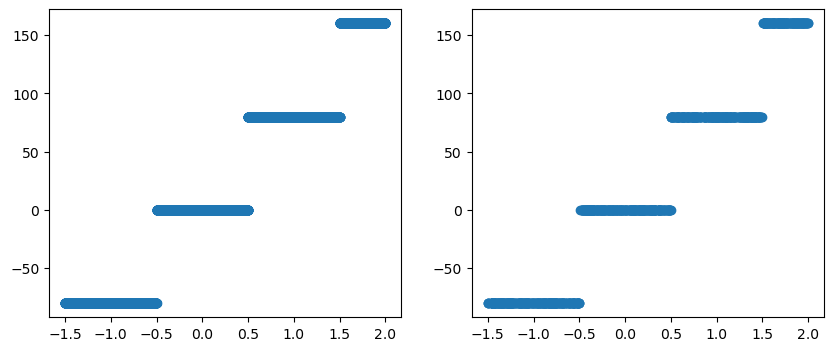

In [96]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_train_steps, y_train_steps)


plt.subplot(1, 2, 2)
plt.scatter(X_test_steps, y_test_steps)
plt.show()

In [299]:
scaler_X = DataScaler(method="min_max")
scaler_y = DataScaler(method="min_max")

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_steps)
y_train_scaled = scaler_y.fit_transform(y_train_steps)
X_test_scaled = scaler_X.fit_transform(X_test_steps)
y_test_scaled = scaler_y.fit_transform(y_test_steps)

In [362]:
np.random.seed(42)

In [363]:
mlp_steps2 = MLP([1, 64, 64, 1], scaler=scaler_y, verbose=False)

In [364]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]
test_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_test_scaled, y_test_scaled)
]
mlp_steps2.train(
    training_data_scaled, epochs=500, learning_rate=0.1, batch_size=10, test_data=test_data_scaled,
    treshold_mse_train=12, treshold_mse_test=9, plot_interval=20
)

# Scale the test data using the transform method (DO NOT refit scaler)
X_test_scaled = scaler_X.transform(X_test_steps)

# Generate predictions on the scaled test data and inverse transform
predictions_scaled = np.array(
    [mlp_steps2.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

train_predictions_scaled = np.array(
    [mlp_steps2.feedforward(x.reshape(-1, 1))[0] for x in X_train_scaled]
)
train_predictions = scaler_y.inverse_transform(train_predictions_scaled.reshape(-1, 1))
print(np.shape(y_train_steps))

# Calculate MSE score
#for i in range(len(predictions)):
    #print("predicted value: ", predictions[i], "actual value: ", y_test_square[i])
mse_score_train = mse(train_predictions, y_train_steps)
print(f"Train MSE Score: {mse_score_train}")
mse_score = mse(predictions, y_test_steps)

print(f"MSE Score: {mse_score}")

Epoch:  0
103078.79273753687
Epoch:  5
209.62826981215895
Epoch:  10
140.13565229596858
Epoch:  15
66.4974047825671
Epoch:  20
54.710587485691114
Epoch:  25
44.16773983733724
Epoch:  30
38.91121989074112
Epoch:  35
34.03441763474374
Epoch:  40
30.250222012884915
Epoch:  45
36.398440535977834
Epoch:  50
26.05423841832119
Epoch:  55
33.49347964547698
Epoch:  60
22.336487921657106
Epoch:  65
24.3818399073151
Epoch:  70
17.73462114195408
Epoch:  75
17.038364338812023
Epoch:  80
19.39500373687884
Epoch:  85
18.647775499577435
Epoch:  90
25.835803662757762
Epoch:  95
15.001288215651556
Epoch:  100
15.90579651316934
Epoch:  105
16.197052069368276
Epoch:  110
13.829295878801416
Epoch:  115
16.083842880432492
Epoch:  120
21.564501930658988
Epoch:  125
14.563339376178492
Epoch:  130
11.772024599270042
10.910914352801134
Epoch:  135
12.170490506871142
Epoch:  140
14.199061956541682
Epoch:  145
14.109987104277694
Epoch:  150
12.413132766661278
Epoch:  155
11.558426271554954
8.58523582807524
(10000

In [377]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]
test_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_test_scaled, y_test_scaled)
]
mlp_steps2.train(
    training_data_scaled, epochs=200, learning_rate=0.005, batch_size=10, adaptive_learning_rate=False, test_data=test_data_scaled,
    treshold_mse_train=10, treshold_mse_test=3, plot_interval=20
)

# Scale the test data using the transform method (DO NOT refit scaler)
X_test_scaled = scaler_X.transform(X_test_steps)

# Generate predictions on the scaled test data and inverse transform
predictions_scaled = np.array(
    [mlp_steps2.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

train_predictions_scaled = np.array(
    [mlp_steps2.feedforward(x.reshape(-1, 1))[0] for x in X_train_scaled]
)
train_predictions = scaler_y.inverse_transform(train_predictions_scaled.reshape(-1, 1))
print(np.shape(y_train_steps))

# Calculate MSE score
#for i in range(len(predictions)):
    #print("predicted value: ", predictions[i], "actual value: ", y_test_square[i])
mse_score_train = mse(train_predictions, y_train_steps)
print(f"Train MSE Score: {mse_score_train}")
mse_score = mse(predictions, y_test_steps)

print(f"MSE Score: {mse_score}")

Epoch:  0
4.965093010059704
8.170044812232529
Epoch:  2
6.997561812431656
3.1405153075614174
Epoch:  4
5.7985412855161265
8.50926688415135
Epoch:  6
6.824189768789896
5.466479700273878
Epoch:  8
6.291239909585488
3.4783460825829633
Epoch:  10
7.1882766172182615
3.3040495065595046
Epoch:  12
9.168758365252051
13.813046135052659
Epoch:  14
6.241480142836049
4.194958814194216
Epoch:  16
6.509832451034383
5.45649209482004
Epoch:  18
8.000999794205848
4.303242569656716
Epoch:  20
5.31059590566809
3.3337841293035444
Epoch:  22
6.808791181658805
9.397469503439938
Epoch:  24
9.009805818287475
7.147567371957002
Epoch:  26
7.188261537586772
7.076830141566435
Epoch:  28
12.85279383741093
Epoch:  30
9.180740402340872
13.301752687264862
Epoch:  32
8.200366602318288
2.669250642537304
(10000, 1)
Train MSE Score: 8.200366602318288
MSE Score: 2.669250642537304


In [382]:
# Scale the test data using the transform method (DO NOT refit scaler)
X_test_scaled = scaler_X.transform(X_test_steps)

# Generate predictions on the scaled test data and inverse transform
predictions_scaled = np.array(
    [mlp_steps2.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))


# Calculate MSE score
#for i in range(len(predictions)):
    #print("predicted value: ", predictions[i], "actual value: ", y_test_square[i])
mse_score = mse(predictions, y_test_steps)

print(f"MSE Score: {mse_score}")

MSE Score: 2.669250642537304


In [379]:
np.random.seed(42)

In [380]:
mlp_steps3 = MLP([1, 64, 64, 1], scaler=scaler_y, verbose=False)

In [383]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]
test_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_test_scaled, y_test_scaled)
]
mlp_steps3.train(
    training_data_scaled, epochs=500, learning_rate=0.1, batch_size=10, test_data=test_data_scaled,
    treshold_mse_train=12, treshold_mse_test=9, plot_interval=20
)

# Scale the test data using the transform method (DO NOT refit scaler)
X_test_scaled = scaler_X.transform(X_test_steps)

# Generate predictions on the scaled test data and inverse transform
predictions_scaled = np.array(
    [mlp_steps3.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

train_predictions_scaled = np.array(
    [mlp_steps3.feedforward(x.reshape(-1, 1))[0] for x in X_train_scaled]
)
train_predictions = scaler_y.inverse_transform(train_predictions_scaled.reshape(-1, 1))
print(np.shape(y_train_steps))

# Calculate MSE score
#for i in range(len(predictions)):
    #print("predicted value: ", predictions[i], "actual value: ", y_test_square[i])
mse_score_train = mse(train_predictions, y_train_steps)
print(f"Train MSE Score: {mse_score_train}")
mse_score = mse(predictions, y_test_steps)

print(f"MSE Score: {mse_score}")

Epoch:  0
103078.79273753687
Epoch:  5
209.62826981215895
Epoch:  10
140.13565229596858
Epoch:  15
66.4974047825671
Epoch:  20
54.710587485691114
Epoch:  25
44.16773983733724
Epoch:  30
38.91121989074112
Epoch:  35
34.03441763474374
Epoch:  40
30.250222012884915
Epoch:  45
36.398440535977834
Epoch:  50
26.05423841832119
Epoch:  55
33.49347964547698
Epoch:  60
22.336487921657106
Epoch:  65
24.3818399073151
Epoch:  70
17.73462114195408
Epoch:  75
17.038364338812023
Epoch:  80
19.39500373687884
Epoch:  85
18.647775499577435
Epoch:  90
25.835803662757762
Epoch:  95
15.001288215651556
Epoch:  100
15.90579651316934
Epoch:  105
16.197052069368276
Epoch:  110
13.829295878801416
Epoch:  115
16.083842880432492
Epoch:  120
21.564501930658988
Epoch:  125
14.563339376178492
Epoch:  130
11.772024599270042
10.910914352801134
Epoch:  135
12.170490506871142
Epoch:  140
14.199061956541682
Epoch:  145
14.109987104277694
Epoch:  150
12.413132766661278
Epoch:  155
11.558426271554954
8.58523582807524
(10000

In [386]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]
test_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_test_scaled, y_test_scaled)
]
mlp_steps3.train(
    training_data_scaled, epochs=200, learning_rate=0.004, batch_size=10, adaptive_learning_rate=False, test_data=test_data_scaled,
    treshold_mse_train=10, treshold_mse_test=3, plot_interval=20
)

# Scale the test data using the transform method (DO NOT refit scaler)
X_test_scaled = scaler_X.transform(X_test_steps)

# Generate predictions on the scaled test data and inverse transform
predictions_scaled = np.array(
    [mlp_steps3.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

train_predictions_scaled = np.array(
    [mlp_steps3.feedforward(x.reshape(-1, 1))[0] for x in X_train_scaled]
)
train_predictions = scaler_y.inverse_transform(train_predictions_scaled.reshape(-1, 1))
print(np.shape(y_train_steps))

# Calculate MSE score
#for i in range(len(predictions)):
    #print("predicted value: ", predictions[i], "actual value: ", y_test_square[i])
mse_score_train = mse(train_predictions, y_train_steps)
print(f"Train MSE Score: {mse_score_train}")
mse_score = mse(predictions, y_test_steps)

print(f"MSE Score: {mse_score}")

Epoch:  0
7.006664494947881
7.517237773609026
Epoch:  2
7.5729195411528405
6.758749619818497
Epoch:  4
6.71371759535063
7.200108145578793
Epoch:  6
9.48300551171383
10.293738240872491
Epoch:  8
12.609245166919965
Epoch:  10
6.9610271380231294
4.010107133497795
Epoch:  12
7.66653190438622
5.692472248031058
Epoch:  14
7.564141736465381
5.233005995463122
Epoch:  16
6.795016971501138
7.850713560465876
Epoch:  18
6.57515974682221
6.3715733073881164
Epoch:  20
10.611527709558134
Epoch:  22
5.647158607884822
4.946824811290565
Epoch:  24
7.671312251237736
4.44832522103306
Epoch:  26
8.026596030718418
8.888269266675518
Epoch:  28
8.090779682460383
12.842957891169432
Epoch:  30
7.111753731798336
6.597063923512025
Epoch:  32
6.549830205090188
3.6615509742856664
Epoch:  34
5.524938472750603
5.417881814731671
Epoch:  36
7.537391398456215
3.855203476620608
Epoch:  38
6.235567619095189
8.847424793380608
Epoch:  40
6.219473383308115
3.87646482885121
Epoch:  42
6.623221071943018
7.220204428917597
Epoch